In [1]:
import tensorflow as tf
from utils import bbox_utils, data_utils, drawing_utils, io_utils, train_utils, eval_utils
from models.decoder import get_decoder_model
from helper import label_generator
from models.ssd_mobilenet_v2 import get_model, init_model
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
batch_size = 8
evaluate = False
backbone = 'mobilenet_v2'

hyper_params = train_utils.get_hyper_params(backbone)

In [3]:
image_feature_description = {
    'image/height': tf.io.FixedLenFeature(shape = (), dtype = np.int64),
    'image/width' : tf.io.FixedLenFeature(shape = (), dtype = np.int64),
    'image/filename' : tf.io.FixedLenFeature(shape = (), dtype = tf.string),
    'image/encoded' : tf.io.FixedLenFeature(shape = (), dtype = tf.string),
    'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/class/text':tf.io.FixedLenSequenceFeature(shape = (), dtype = tf.string, allow_missing = True),
    'image/object/class/label':tf.io.FixedLenSequenceFeature(shape = (), dtype = np.int64, allow_missing = True)
}

def _parse_data(unparsed_example):
    return tf.io.parse_single_example(unparsed_example, image_feature_description)

def _bytestring(parsed_example):
    byte_string = parsed_example['image/encoded']
    image = tf.io.decode_image(byte_string)
    image = tf.reshape(image, [300, 300, 3])
    parsed_example['image/encoded'] = image
    bbox = tf.stack([parsed_example['image/object/bbox/ymin'], parsed_example['image/object/bbox/xmin'], parsed_example['image/object/bbox/ymax'], parsed_example['image/object/bbox/xmax']], axis = -1)
    output_dict = {'image': image,
                  'objects': {
                      'bbox': bbox,
                      'label':parsed_example['image/object/class/label']
                  }}

    return output_dict

def get_dataset(path):
    dataset = tf.data.TFRecordDataset(path)
    dataset = dataset.map(_parse_data)
    dataset = dataset.map(_bytestring)
    size_info = dataset.reduce(0, lambda x, _ : x + 1).numpy()
    return dataset, size_info

In [61]:
test_data, size_info = get_dataset(r"F:\Minor Data Collection\Final Image Data\Monument Original\Merged_Original_Augmented\test_aug.tfrecord")
total_items = size_info

In [5]:
labels = ['bg', 'badrinath temple', 'basantapur tower', 'bhagavati temple', 'bhairavnath temple', 'bhaktapur tower', 'bhimeleshvara', 'bhimsen temple', 'bhupatindra malla column', 'bhuvana lakshmeshvara', 'chasin dega', 'chayasilin mandap', 'dattatreya temple', 'degu tale temple_KDS', 'fasidega temple', 'gaddi durbar', 'garud', 'golden gate', 'gopinath krishna temple', 'hanuman idol', 'indrapura', 'jagannatha temple', 'kala-bhairava', 'kasthamandap', 'kavindrapura sattal', 'kedamatha tirtha', 'kirtipur tower', 'kumari ghar', 'lalitpur tower', 'mahadev temple', 'narayan temple', 'national gallery', 'nyatapola temple', 'palace of the 55 windows', 'panchamukhi hanuman', 'pratap malla column', 'shiva temple', 'shveta bhairava', 'siddhi lakshmi temple', 'simha sattal', 'taleju bell_BDS', 'taleju bell_KDS', 'taleju temple', 'trailokya mohan', 'vastala temple', 'vishnu temple']
hyper_params["total_labels"] = len(labels)
img_size = hyper_params["img_size"]

In [62]:
data_types = data_utils.get_data_types()
data_shapes = data_utils.get_data_shapes()
padding_values = data_utils.get_padding_values()

test_data = test_data.map(lambda x : data_utils.preprocessing(x, img_size, img_size))
test_data = test_data.padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)

In [7]:
ssd_model = get_model(hyper_params)
ssd_model_path = io_utils.get_model_path(backbone)
ssd_model.load_weights("./trained/ssd_mobilenet_v2_model_weights_150_epch 1e-3 and 1e-4.h5")
prior_boxes = bbox_utils.generate_prior_boxes(hyper_params["feature_map_shapes"], hyper_params["aspect_ratios"])
ssd_decoder_model = get_decoder_model(ssd_model, prior_boxes, hyper_params)

In [8]:
step_size = train_utils.get_step_size(total_items, batch_size)
pred_bboxes, pred_labels, pred_scores = ssd_decoder_model.predict(test_data, steps=step_size, verbose=1)

261/261 [==============================] - 108s 410ms/step


###  Calculate PR Curve

In [63]:
stats = eval_utils.evaluate_predictions(test_data, pred_bboxes, pred_labels, pred_scores, labels, batch_size)

mAP: 0.7833850746454991


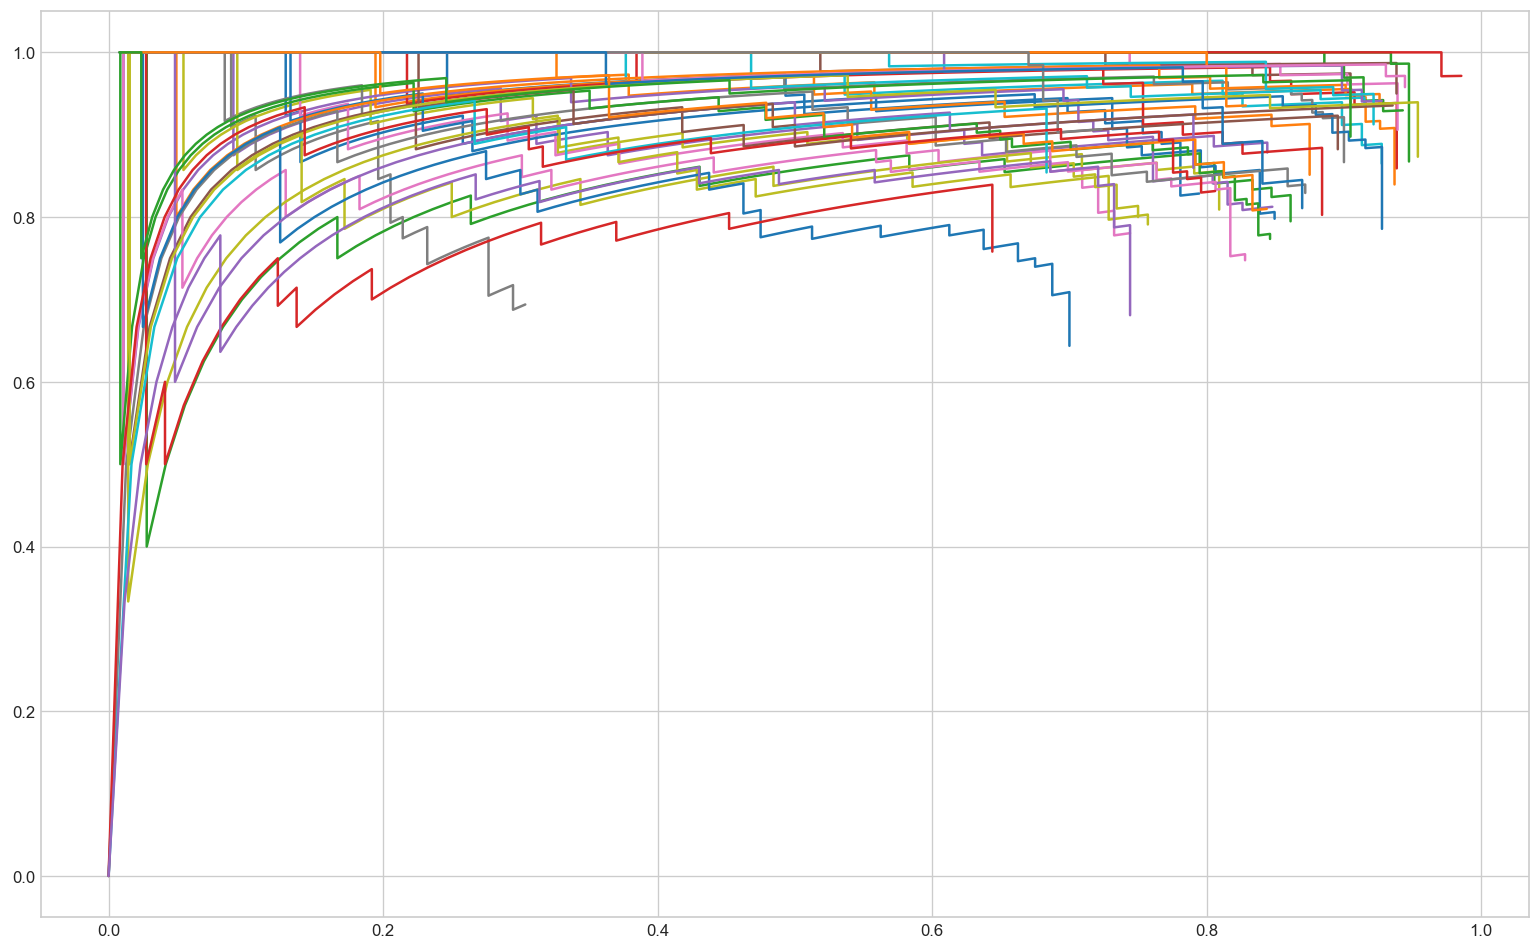

In [68]:
plt.figure(figsize = (16, 10), dpi = 120)
for i in range(1, len(labels)):
    plt.plot(stats[i]['recall'], stats[i]['precision'])
plt.show()


In [73]:
test_data, size_info = get_dataset(r"F:\Minor Data Collection\Final Image Data\Monument Original\Merged_Original_Augmented\test_aug.tfrecord")
test_data = test_data.map(lambda x : data_utils.preprocessing(x, img_size, img_size))

In [74]:
def IOU_score(pred_bbox, gt_bbox, width = 300, height = 300):
    p_y1, p_x1, p_y2, p_x2 = pred_bbox
    gt_y1, gt_x1, gt_y2, gt_x2 = gt_bbox

    p_y1, p_x1, p_y2, p_x2 = int(p_y1 * height), int(p_x1 * width), int(p_y2 * height), int(p_x2 * width)
    gt_y1, gt_x1, gt_y2, gt_x2 = int(gt_y1 * height), int(gt_x1 * width), int(gt_y2 * height), int(gt_x2 * width)
    
    area_pbox = (p_x2 - p_x1) * (p_y2 - p_y1)
    area_gtbox = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)

    xx = max(p_x1, gt_x1)
    yy = max(p_y1, gt_y1)
    aa = min(p_x2, gt_x2)
    bb = min(p_y2, gt_y2)

    w = max(0, aa - xx)
    h = max(0, bb - yy)

    intersection_area = w * h

    if intersection_area == 0:
        return 0
    union_area = area_pbox + area_gtbox - intersection_area
    return float(intersection_area) / float(union_area)

In [198]:
precision_list = []
recall_list = []
def PR_Curve():
    for iou_threshold in np.arange(0.5, 0.96, 0.05).tolist():
        image_no = 0
        data_list = []
        accumulated_TP = 0
        accumulated_FP = 0
        gt_ROIs = 0

        for index, ele in enumerate(test_data):
            gt_ind_ROI = 0
            image_name = 'Image ' + str(image_no)

            bounding_boxes = ele[1].numpy()
            class_labels = ele[2].numpy()

            predicted_pred_bboxes = pred_bboxes[index]
            pred_class_labels = pred_labels[index]
            pred_conf_scores = pred_scores[index]

            for _ in class_labels:
                gt_ind_ROI += 1
            gt_ROIs += gt_ind_ROI

            detected_count = 0
            for bbox in predicted_pred_bboxes:
                if bbox[0] > 0 or bbox[1] > 0 or bbox[2] > 0 or bbox[3] > 0:
                    detected_count += 1
                else:
                    break
                    
    
            for i in range(detected_count):
                tp = 0
                fp = 0
                
                for j, bbox in enumerate(bounding_boxes):
                    if IOU_score(predicted_pred_bboxes[i], bbox) > iou_threshold:
                        if pred_class_labels[i] == class_labels[j]:
                            tp = 1
                        else:
                            fp = 1
                        break  
                if pred_class_labels[i] not in class_labels:
                    fp = 1

                    
                data_list.append((image_name, labels[int(pred_class_labels[i])], pred_conf_scores[i] * 100, tp, fp, len(class_labels)))

            image_no += 1

        column_name = ['Image', 'Detection', 'Confidence', "TP", "FP", 'Counts']
        df = pd.DataFrame(data_list, columns = column_name)

        df.sort_values(['Confidence'], inplace = True, ignore_index=True, ascending = False)

        new_data_list = list()
        accumulated_TP = 0
        accumulated_FP = 0

        for row in df.iterrows():
            if row[1]['TP'] == 1:
                accumulated_TP += 1
            elif row[1]['FP'] == 1:
                accumulated_FP += 20
            try:
                precision = float(accumulated_TP) / (float(accumulated_TP) + float(accumulated_FP))
            except ZeroDivisionError:
                precision = 1.0
            recall = float(accumulated_TP) / gt_ROIs
            new_data_list.append((row[1]['Image'], row[1]['Detection'], row[1]['Confidence'], row[1]['TP'], row[1]['FP'], accumulated_TP, accumulated_FP, precision, recall))

        column_name = ['Image', 'Detections', 'Confidence %', "TP", "FP", 'Acc TP', 'Acc FP', 'Precision', 'Recall']
        new_df = pd.DataFrame(new_data_list, columns = column_name)
        precision_list.append(new_df['Precision'])
        recall_list.append(new_df['Recall'])

In [199]:
PR_Curve()

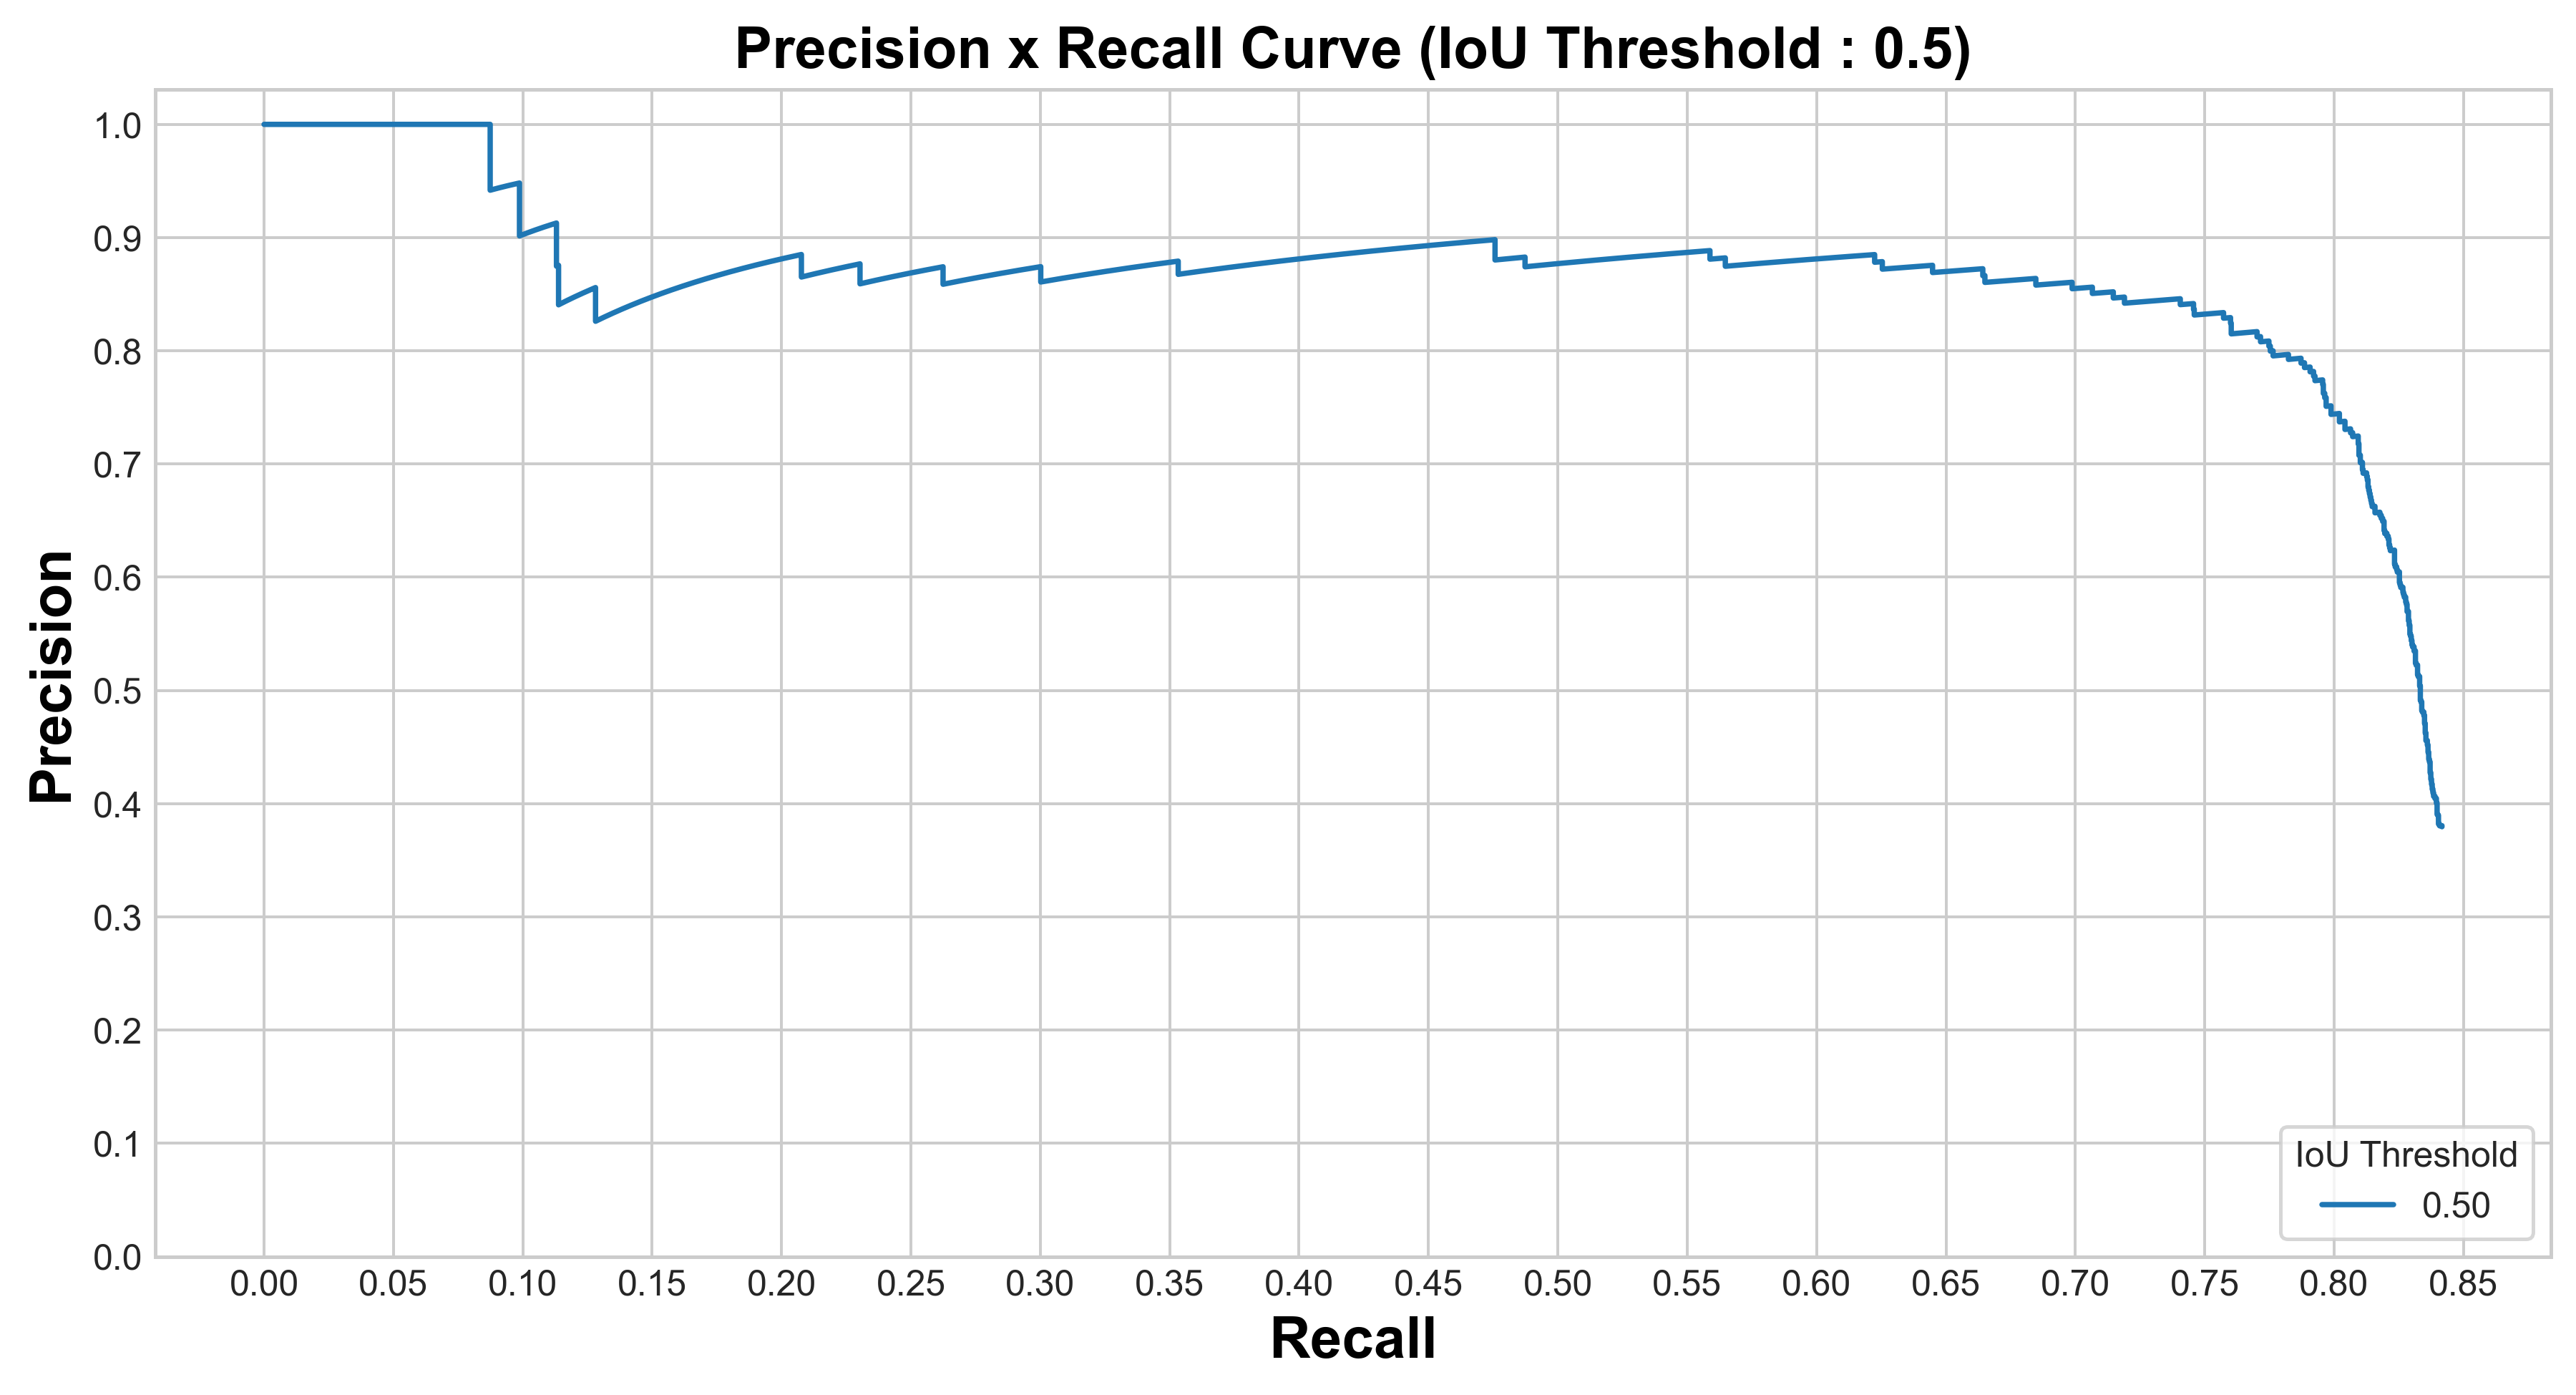

In [209]:
plt.figure(figsize = (12, 6), dpi = 360)
plt.style.use('seaborn-whitegrid')
font = {'color': 'black', 'size': 16, 'weight': 'bold'}
threshold_range = np.arange(0.5, 0.96, 0.05)


plt.plot(recall_list[0], precision_list[0], label = "%.2f" % threshold_range[0])
plt.xlabel('Recall', fontdict = font)
plt.ylabel('Precision', fontdict = font)
plt.title(f'Precision x Recall Curve (IoU Threshold : 0.5)', font)
plt.legend(loc = 'lower right', title = 'IoU Threshold', frameon = True)
plt.xticks(np.arange(0, 0.9, 0.05))
plt.yticks(np.arange(0, 1.1, 0.1))
save_loc = r'./Curves and Graphs/Precision x Recall Curve for 0.5 IoU Threshold.jpg'
plt.savefig(save_loc, dpi = 360, bbox_inches = 'tight', pad_inches = 0.3)
plt.show()

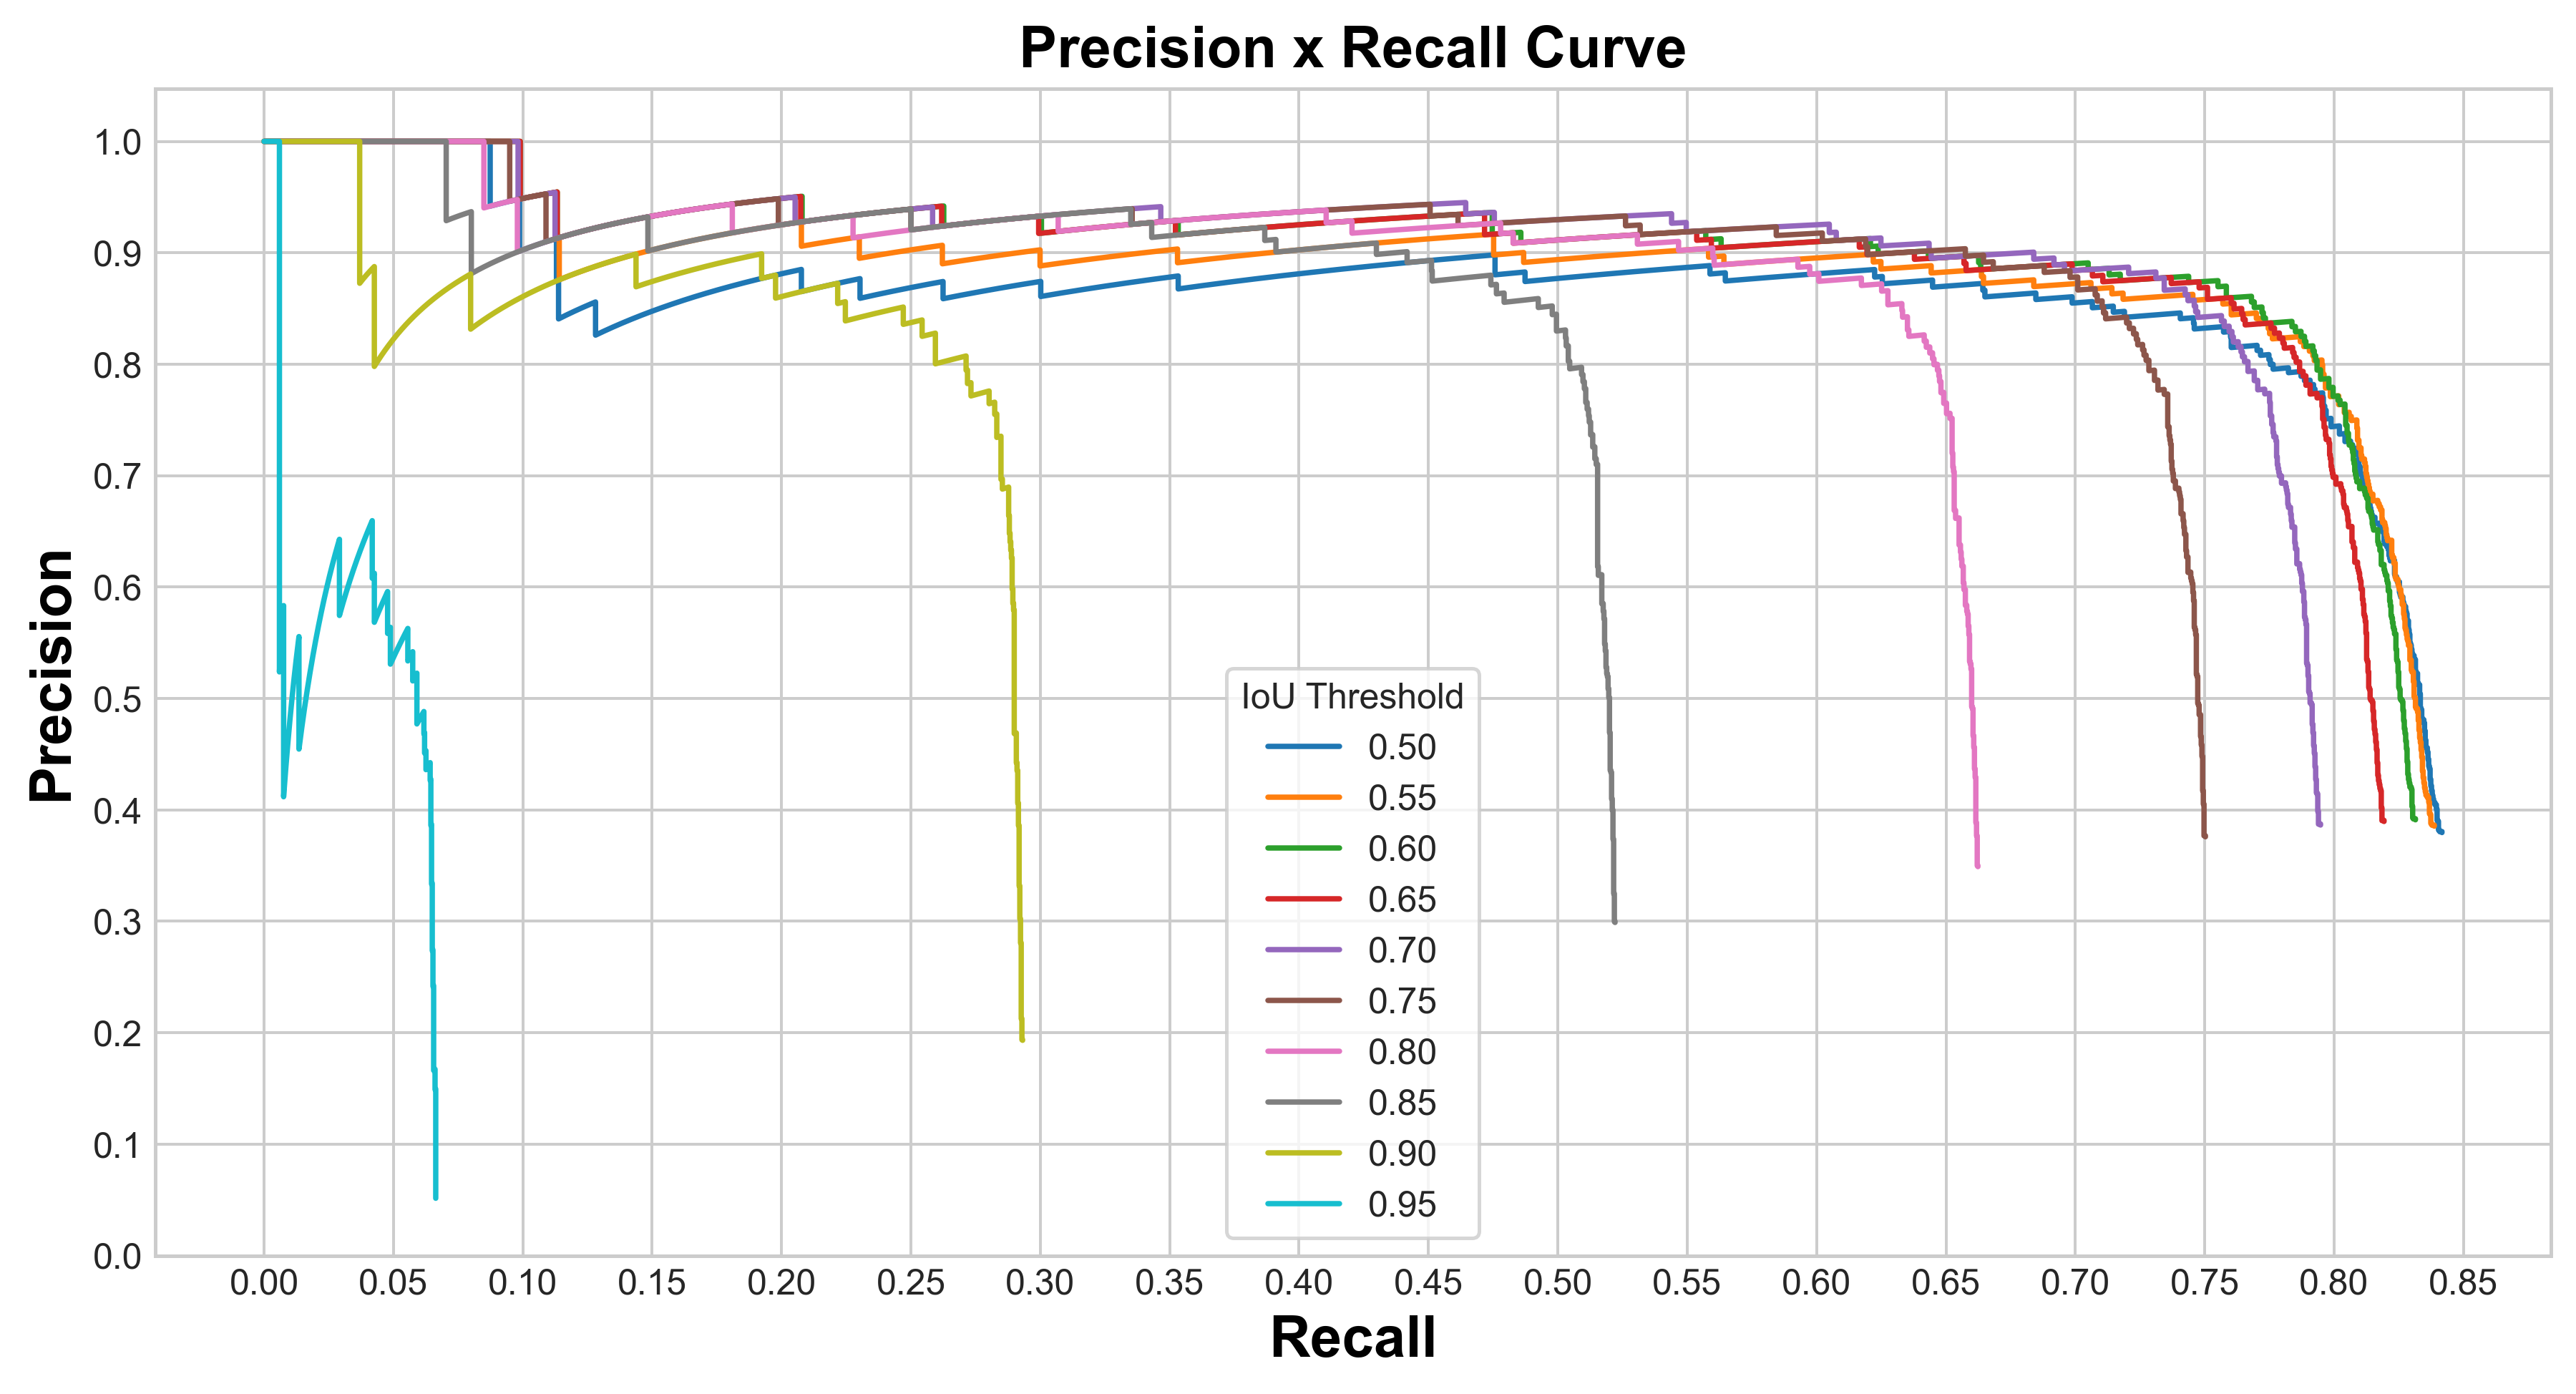

In [205]:
plt.figure(figsize = (12, 6), dpi = 360)
plt.style.use('seaborn-whitegrid')
font = {'color': 'black', 'size': 16, 'weight': 'bold'}
threshold_range = np.arange(0.5, 0.96, 0.05)

for i in range(len(precision_list)):
    plt.plot(recall_list[i], precision_list[i], label = "%.2f" % threshold_range[i])
#     plt.scatter(recall_list[i], precision_list[i], s = 8)
    plt.xlabel('Recall', fontdict = font)
    plt.ylabel('Precision', fontdict = font)
    plt.title(f'Precision x Recall Curve', font)
    
plt.legend(loc = 'best', title = 'IoU Threshold', frameon = True)
plt.xticks(np.arange(0, 0.9, 0.05))
plt.yticks(np.arange(0, 1.1, 0.1))
# plt.savefig("Precision x Recall Curve-0.5 to 0.95.jpg", dpi = 360, bbox_inches = 'tight', pad_inches = 0.3)
plt.show()

In [202]:
import math
def calculate_p(rv, hp, lp, hr, lr):
    value = lp + ((hp-lp)/(hr-lr)) * (rv - lr)
    if math.isinf(value):
        return lp
    else:
        return value

In [203]:
eleven_point = np.arange(0.0, 1.1, 0.1).tolist()

output_AP_list = list()
for i in range(len(precision_list)):
    list_size = len(precision_list[i])
    
    points_precision_val = list()
    for interpolation_point in eleven_point:
        for val_index in range(list_size):
            if recall_list[i][val_index] > interpolation_point:
                if val_index == 0:
                    points_precision_val.append(precision_list[i][val_index])
                    break
                else:
                    recall_value = interpolation_point
                    high_p = precision_list[i][val_index]
                    low_p = precision_list[i][val_index - 1]
                    high_r = recall_list[i][val_index]
                    low_r = recall_list[i][val_index - 1]
                    points_precision_val.append(calculate_p(recall_value, high_p, low_p, high_r, low_r))
                    break
    output_AP_list.append(np.sum(np.array(points_precision_val)) / 11)

[0.7178738331493902, 0.7361467325915986, 0.7489710552556645, 0.7404164130085142, 0.682410040109112, 0.6790203082410842, 0.5900188106045386, 0.499383412556694, 0.24740439115351104, 0.09090909090909091]


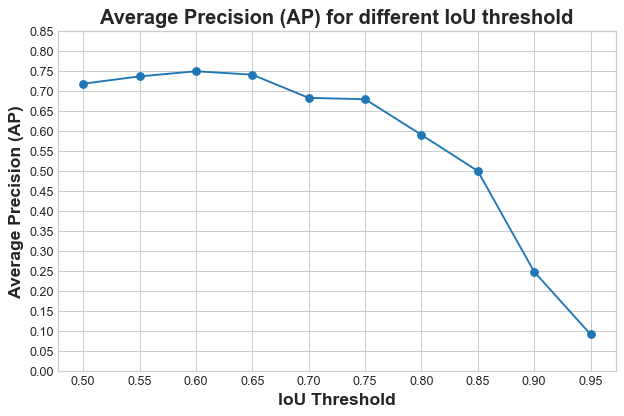

In [204]:
print(output_AP_list)
plt.figure(figsize = (8, 5), dpi = 90)
plt.plot(np.arange(0.5, 0.96, 0.05), output_AP_list)
plt.scatter(np.arange(0.5, 0.96, 0.05), output_AP_list, )

plt.xticks(np.arange(0.5, 0.96, 0.05))
plt.yticks(np.arange(0.0, 0.9, 0.05))
font_title = {'size': 16, 'weight': 'bold'}
font_label = {'size': 14, 'weight': 'bold'}

plt.title('Average Precision (AP) for different IoU threshold', fontdict = font_title)
plt.xlabel('IoU Threshold', fontdict = font_label)
plt.ylabel('Average Precision (AP)', fontdict = font_label)
# plt.savefig("Average Precision(AP) for different IoU threshold.jpg", dpi = 90, bbox_inches = 'tight', pad_inches = 0.3)
plt.show()

In [136]:
def get_mn_dataframe(threshold = 0.5):
    
    global gt_ROIs
    accumulated_TP = 0
    accumulated_FP = 0
    data_list = list()
    image_no = 0
    iou_threshold = threshold # From AP vs IoU threshold curve

    for index, ele in enumerate(test_data):
#         gt_ind_ROI = 0
        image_name = 'Image ' + str(image_no)
        # Ground truth bboxes
        bounding_boxes = ele[1].numpy()
        # Ground truth class labels
        class_labels = ele[2].numpy()
        # Predicted bboxes
        predicted_pred_bboxes = pred_bboxes[index]
        # Predicted class labels
        pred_class_labels = pred_labels[index]
        # Predicted confidence scores
        pred_conf_scores = pred_scores[index]
        # Finding total gt-bboxes ROIs
#         for _ in class_labels:
#             gt_ind_ROI += 1
#         gt_ROIs += gt_ind_ROI
        # Finding number of predictions carried out by the model
        detected_count = 0
        for bbox in predicted_pred_bboxes:
            if bbox[0] > 0 or bbox[1] > 0 or bbox[2] > 0 or bbox[3] > 0:
                detected_count += 1
            else:
                break
                
        for i in range(detected_count):
            tp = 0
            fp = 0
                
            for j, bbox in enumerate(bounding_boxes):
                if IOU_score(predicted_pred_bboxes[i], bbox) > iou_threshold:
                    if pred_class_labels[i] == class_labels[j]:
                        tp = 1
                    else:
                        fp = 1
                    break  
            if pred_class_labels[i] not in class_labels:
                fp = 1
    
            data_list.append((image_name, labels[int(pred_class_labels[i])], pred_conf_scores[i] * 100, tp, fp))

        image_no += 1

    column_name = ['Image', 'Detection', 'Confidence', "TP", "FP"]
    df = pd.DataFrame(data_list, columns = column_name)
    return df

In [137]:
def dataframe_to_mn_dict(threshold):
    mn_dict = dict()
    for row in get_mn_dataframe(threshold).iterrows():
        mn_class = row[1]['Detection']
        mn_conf_score = row[1]['Confidence']
        tp = row[1]['TP']
        fp = row[1]['FP']

        if mn_class in list(mn_dict.keys()):
            mn_dict[mn_class]['conf_scores'].append(mn_conf_score)
            mn_dict[mn_class]['tp'].append(tp)
            mn_dict[mn_class]['fp'].append(fp)
        else:
            temp_dict = {
                'conf_scores': [mn_conf_score],
                'tp': [tp],
                'fp': [fp]
            }
            mn_dict[mn_class] = temp_dict 
    return mn_dict


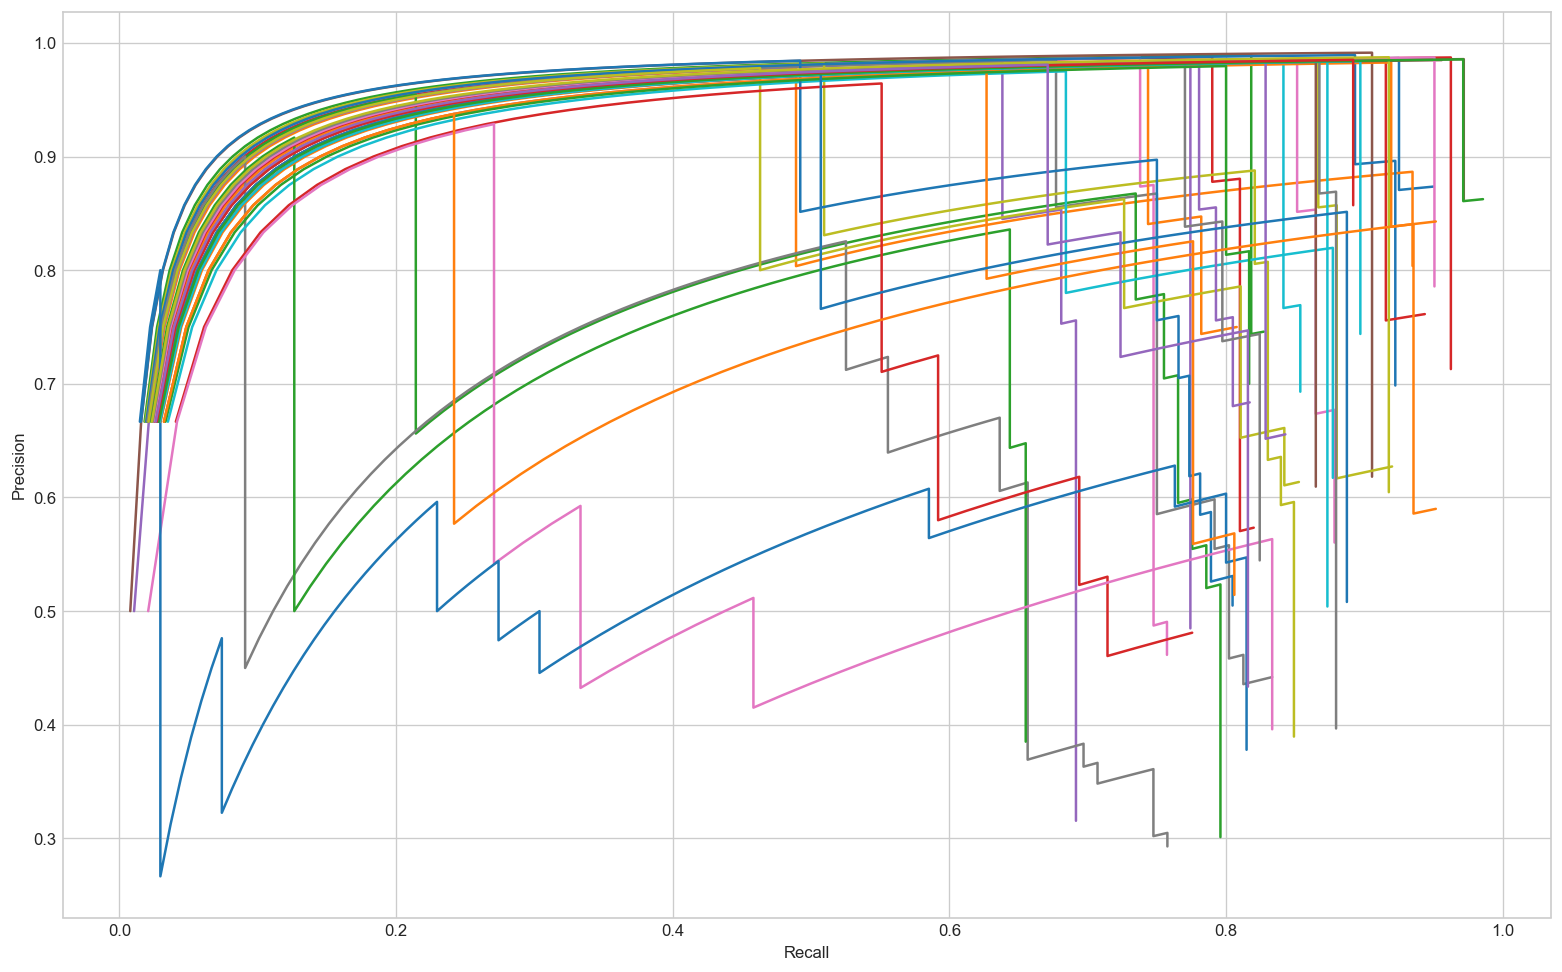

In [147]:
sub_plot_count = 1
img_batch_plot = 1
font_title = {'size': 14, 'weight' : 'bold'}
plt.figure(figsize = (16, 10), dpi = 120)

mn_dict = dataframe_to_mn_dict(0.5)
for mn_class, mn_info in mn_dict.items():
    column_names = ['conf_scores', 'tp', 'fp']
    temp_df = pd.DataFrame(zip(mn_info['conf_scores'], mn_info['tp'], mn_info['fp']), columns = column_names)
    temp_df.sort_values(['conf_scores'], inplace = True, ignore_index = True, ascending = False)
    gt_ROI = len(list(temp_df['conf_scores']))

    acc_tp = 1
    acc_fp = 1

    precision_list = list()
    recall_list = list()
    for row in temp_df.iterrows():
        if row[1]['tp'] == 1:
            acc_tp += 1
        elif row[1]['fp'] == 1:
            acc_fp += 10
        
        try: 
            precision_list.append(float(acc_tp) / (float(acc_tp) + float(acc_fp)))
        except ZeroDivisionError:
            precision_list.append(1.0)
        recall_list.append(float(acc_tp) / gt_ROI)

    # plotting PR curve for each monument class
    
    plt.plot(recall_list, precision_list, label = mn_class)
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.legend(loc = 'best')
plt.show()
    
    

In [150]:
# sub_plot_count = 1
# img_batch_plot = 1
# font_title = {'size': 14, 'weight' : 'bold'}

def calculate_mAP(threshold):
    mn_dict = dataframe_to_mn_dict(threshold)
    for mn_class, mn_info in mn_dict.items():
        column_names = ['conf_scores', 'tp', 'fp']
        temp_df = pd.DataFrame(zip(mn_info['conf_scores'], mn_info['tp'], mn_info['fp']), columns = column_names)
        temp_df.sort_values(['conf_scores'], inplace = True, ignore_index = True, ascending = False)
        gt_ROI = len(list(temp_df['conf_scores']))

        acc_tp = 1
        acc_fp = 1

        precision_list = list()
        recall_list = list()
        for row in temp_df.iterrows():
            if row[1]['tp'] == 1:
                acc_tp += 1
            elif row[1]['fp'] == 1:
                acc_fp += 1
            precision_list.append(float(acc_tp) / (float(acc_tp) + float(acc_fp)))
            recall_list.append(float(acc_tp) / gt_ROI)

        # Calculating AP value for each monument class

        list_size = len(precision_list)
        points_precision_val = list()
        eleven_point = np.arange(0.0, 1.1, 0.1).tolist()
        for interpolation_point in eleven_point:
            for val_index in range(list_size):
                if recall_list[val_index] > interpolation_point:
                    if val_index == 0:
                        points_precision_val.append(precision_list[val_index])
                        break
                    else:
                        recall_value = interpolation_point
                        high_p = precision_list[val_index]
                        low_p = precision_list[val_index - 1]
                        high_r = recall_list[val_index]
                        low_r = recall_list[val_index - 1]
                        points_precision_val.append(calculate_p(recall_value, high_p, low_p, high_r, low_r))
                        break
        mn_dict[mn_class]['AP'] = np.sum(np.array(points_precision_val)) / 11
    mAP_score = 0
    total_mn_class = len(list(mn_dict.keys()))
    for _, mn_info in mn_dict.items():
        mAP_score += mn_info['AP']
    return (mAP_score / total_mn_class)

In [151]:
iou_threshold_range = np.arange(0.1, 0.96, 0.05).tolist()
map_scores_list = list()

for threshold in iou_threshold_range:
    map_score = calculate_mAP(threshold)
    map_scores_list.append(map_score)
    print(f"mAP Score at threshold: {threshold} is {map_score}")

mAP Score at threshold: 0.1 is 0.6405897919858714
mAP Score at threshold: 0.15000000000000002 is 0.685511234718708
mAP Score at threshold: 0.20000000000000004 is 0.7188858153956662
mAP Score at threshold: 0.25000000000000006 is 0.7437168261785133
mAP Score at threshold: 0.30000000000000004 is 0.7491563409542271
mAP Score at threshold: 0.3500000000000001 is 0.7567015591386114
mAP Score at threshold: 0.40000000000000013 is 0.7627265643344082
mAP Score at threshold: 0.45000000000000007 is 0.761368278709894
mAP Score at threshold: 0.5000000000000001 is 0.7614840798153832
mAP Score at threshold: 0.5500000000000002 is 0.7569055947423092
mAP Score at threshold: 0.6000000000000002 is 0.7520107484011849
mAP Score at threshold: 0.6500000000000001 is 0.7416347056478225
mAP Score at threshold: 0.7000000000000002 is 0.7064995892996104
mAP Score at threshold: 0.7500000000000002 is 0.6767487483417919
mAP Score at threshold: 0.8000000000000002 is 0.5977776241910577
mAP Score at threshold: 0.8500000000

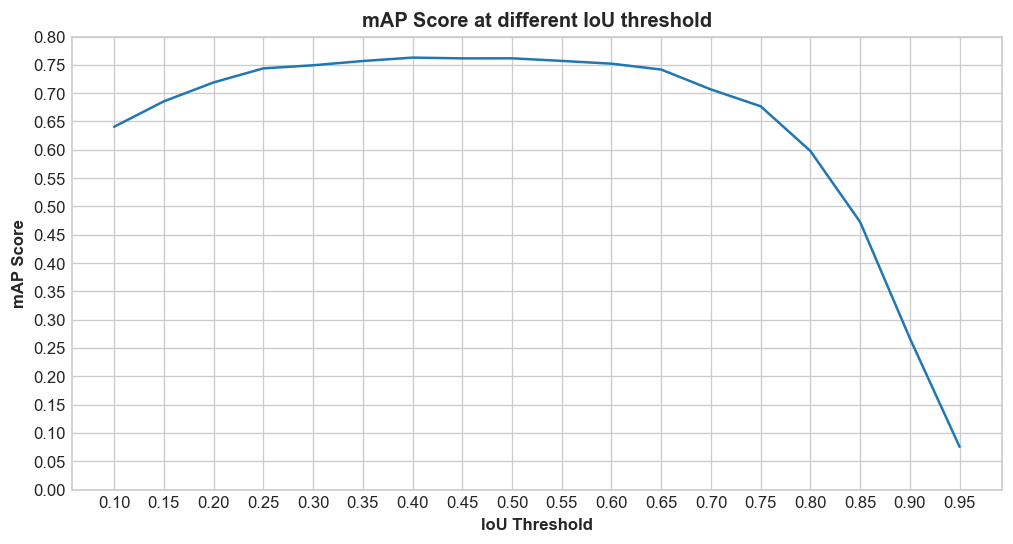

In [153]:
plt.figure(figsize = (10, 5), dpi = 120)
plt.plot(iou_threshold_range, map_scores_list)
plt.xticks(iou_threshold_range)
plt.yticks(np.arange(0.0, 0.85, 0.05))

plt.title('mAP Score at different IoU threshold', fontdict = {'size': 12, 'weight': 'bold'})
plt.xlabel('IoU Threshold', fontdict = {'size': 10, 'weight': 'bold'})
plt.ylabel('mAP Score', fontdict = {'size': 10, 'weight': 'bold'})
save_loc = "./Curves and Graphs/mAP Scores at different IoU threshold_Final.jpg"
plt.savefig(save_loc, dpi = 160, bbox_inches = 'tight', pad_inches = 0.2)
plt.show()